In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from operator import attrgetter
import matplotlib.colors as mcolors
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

Читаем датасет, преобразуем данные

In [87]:
df = pd.read_csv('superstore.csv', 
                 dtype={'row_id': str,
                          'order_id': str,
                       'customer_id': str},
                 parse_dates=['order_date', 'ship_date'])
df.head()

,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,country,city,...,postal_code,region,product_id,category,sub_category,product_name,sales,quantity,discount,profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   row_id         9994 non-null   object        
 1   order_id       9994 non-null   object        
 2   order_date     9994 non-null   datetime64[ns]
 3   ship_date      9994 non-null   datetime64[ns]
 4   ship_mode      9994 non-null   object        
 5   customer_id    9994 non-null   object        
 6   customer_name  9994 non-null   object        
 7   segment        9994 non-null   object        
 8   country        9994 non-null   object        
 9   city           9994 non-null   object        
 10  state          9994 non-null   object        
 11  postal_code    9994 non-null   int64         
 12  region         9994 non-null   object        
 13  product_id     9994 non-null   object        
 14  category       9994 non-null   object        
 15  sub_category   9994 n

Пропуски данных отсутствуют

In [89]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
postal_code,9994.0,55190.379428,32063.693350,1040.000,23223.00000,56430.5000,90008.000,99301.000
sales,9994.0,229.858001,623.245101,0.444,17.28000,54.4900,209.940,22638.480
quantity,9994.0,3.789574,2.225110,1.000,2.00000,3.0000,5.000,14.000
discount,9994.0,0.156203,0.206452,0.000,0.00000,0.2000,0.200,0.800
profit,9994.0,28.656896,234.260108,-6599.978,1.72875,8.6665,29.364,8399.976


## Считаем метрики

In [70]:
num_orders = df.groupby(['customer_id'])['order_id'].nunique()
orders_per_user = np.sum(num_orders) / df['customer_id'].nunique()
print('Число заказов на одного пользователя равно {:.2f}.'.format(orders_per_user))

Число заказов на одного пользователя равно 6.32.


Присутсвуют пользователи, делающие более одного заказа.

In [71]:
orders_per_user_l2 = np.sum(num_orders > 1) / df['customer_id'].nunique()
print('Процент пользователей совершивших более одного заказа {:.2%}.'.format(orders_per_user_l2))

Процент пользователей совершивших более одного заказа 98.49%.


Большинство пользователей делают более одного заказа

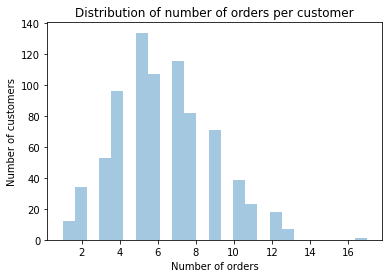

In [72]:
ax = sns.distplot(num_orders, kde=False, hist=True)
ax.set(title='Distribution of number of orders per customer',
       xlabel='Number of orders', 
       ylabel='Number of customers');

Большая часть покупателей сделали 5 заказов, есть определенное количество пользователей сделавших более 26 заказов

## Когортный анализ

Удаляем дубликаты

In [73]:
df = df[['customer_id', 'order_id', 'order_date']].drop_duplicates()

Разбиваем на когорты по месяцам

In [74]:
df['order_month'] = df['order_date'].dt.to_period('M')
df['cohort'] = df.groupby('customer_id')['order_date'].transform('min').dt.to_period('M') 
df.sample(5)

,customer_id,order_id,order_date,order_month,cohort
1865,NG-18355,US-2017-116659,2017-11-12,2017-11,2014-11
5249,BN-11470,CA-2015-106215,2015-04-16,2015-04,2014-09
334,DB-13615,CA-2015-137946,2015-09-01,2015-09,2014-09
9337,RP-19270,CA-2014-155264,2014-10-19,2014-10,2014-10
2710,GH-14425,US-2015-120572,2015-12-11,2015-12,2014-06


Сделаем группировку по когорте и месяцу заказа

In [75]:
df_cohort = df.groupby(['cohort', 'order_month']).agg(n_customers=('customer_id', 'nunique')).reset_index(drop=False)
df_cohort.sample()

,cohort,order_month,n_customers
553,2015-03,2016-06,2


Введем номер периода 

In [76]:
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))
df_cohort.sample(3)

,cohort,order_month,n_customers,period_number
591,2015-04,2017-12,3,32
281,2014-07,2016-04,5,21
248,2014-06,2016-10,10,28


Создадим когортный отчет

In [77]:
cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')
cohort_pivot

period_number,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
cohort,,,,,,,,,,,,,,,,,,,,,
2014-01,32.0,3.0,NaN,2.0,2.0,NaN,2.0,4.0,5.0,3.0,...,6.0,4.0,5.0,4.0,1.0,2.0,9.0,9.0,10.0,6.0
2014-02,24.0,4.0,2.0,1.0,NaN,2.0,2.0,3.0,3.0,4.0,...,2.0,2.0,5.0,3.0,3.0,4.0,6.0,6.0,3.0,NaN
2014-03,65.0,4.0,2.0,8.0,7.0,NaN,7.0,5.0,8.0,6.0,...,13.0,10.0,12.0,6.0,19.0,8.0,18.0,16.0,NaN,NaN
2014-04,56.0,6.0,2.0,4.0,3.0,8.0,6.0,9.0,8.0,1.0,...,5.0,7.0,8.0,15.0,8.0,14.0,14.0,NaN,NaN,NaN
2014-05,56.0,5.0,5.0,4.0,10.0,2.0,12.0,10.0,4.0,3.0,...,7.0,6.0,16.0,7.0,17.0,9.0,NaN,NaN,NaN,NaN
2014-06,48.0,1.0,2.0,4.0,2.0,9.0,8.0,1.0,4.0,6.0,...,3.0,13.0,7.0,14.0,11.0,NaN,NaN,NaN,NaN,NaN
2014-07,44.0,6.0,5.0,NaN,5.0,8.0,2.0,NaN,8.0,2.0,...,11.0,10.0,13.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN
2014-08,49.0,8.0,3.0,11.0,5.0,3.0,4.0,2.0,4.0,3.0,...,12.0,11.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09,68.0,9.0,9.0,11.0,1.0,2.0,9.0,10.0,9.0,2.0,...,16.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Retention matrix

In [78]:
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)
retention_matrix

period_number,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
cohort,,,,,,,,,,,,,,,,,,,,,
2014-01,1.0,0.093750,NaN,0.062500,0.062500,NaN,0.062500,0.125000,0.156250,0.093750,...,0.187500,0.125000,0.156250,0.125000,0.031250,0.062500,0.281250,0.281250,0.3125,0.1875
2014-02,1.0,0.166667,0.083333,0.041667,NaN,0.083333,0.083333,0.125000,0.125000,0.166667,...,0.083333,0.083333,0.208333,0.125000,0.125000,0.166667,0.250000,0.250000,0.1250,NaN
2014-03,1.0,0.061538,0.030769,0.123077,0.107692,NaN,0.107692,0.076923,0.123077,0.092308,...,0.200000,0.153846,0.184615,0.092308,0.292308,0.123077,0.276923,0.246154,NaN,NaN
2014-04,1.0,0.107143,0.035714,0.071429,0.053571,0.142857,0.107143,0.160714,0.142857,0.017857,...,0.089286,0.125000,0.142857,0.267857,0.142857,0.250000,0.250000,NaN,NaN,NaN
2014-05,1.0,0.089286,0.089286,0.071429,0.178571,0.035714,0.214286,0.178571,0.071429,0.053571,...,0.125000,0.107143,0.285714,0.125000,0.303571,0.160714,NaN,NaN,NaN,NaN
2014-06,1.0,0.020833,0.041667,0.083333,0.041667,0.187500,0.166667,0.020833,0.083333,0.125000,...,0.062500,0.270833,0.145833,0.291667,0.229167,NaN,NaN,NaN,NaN,NaN
2014-07,1.0,0.136364,0.113636,NaN,0.113636,0.181818,0.045455,NaN,0.181818,0.045455,...,0.250000,0.227273,0.295455,0.204545,NaN,NaN,NaN,NaN,NaN,NaN
2014-08,1.0,0.163265,0.061224,0.224490,0.102041,0.061224,0.081633,0.040816,0.081633,0.061224,...,0.244898,0.224490,0.204082,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09,1.0,0.132353,0.132353,0.161765,0.014706,0.029412,0.132353,0.147059,0.132353,0.029412,...,0.235294,0.176471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Визуализируем

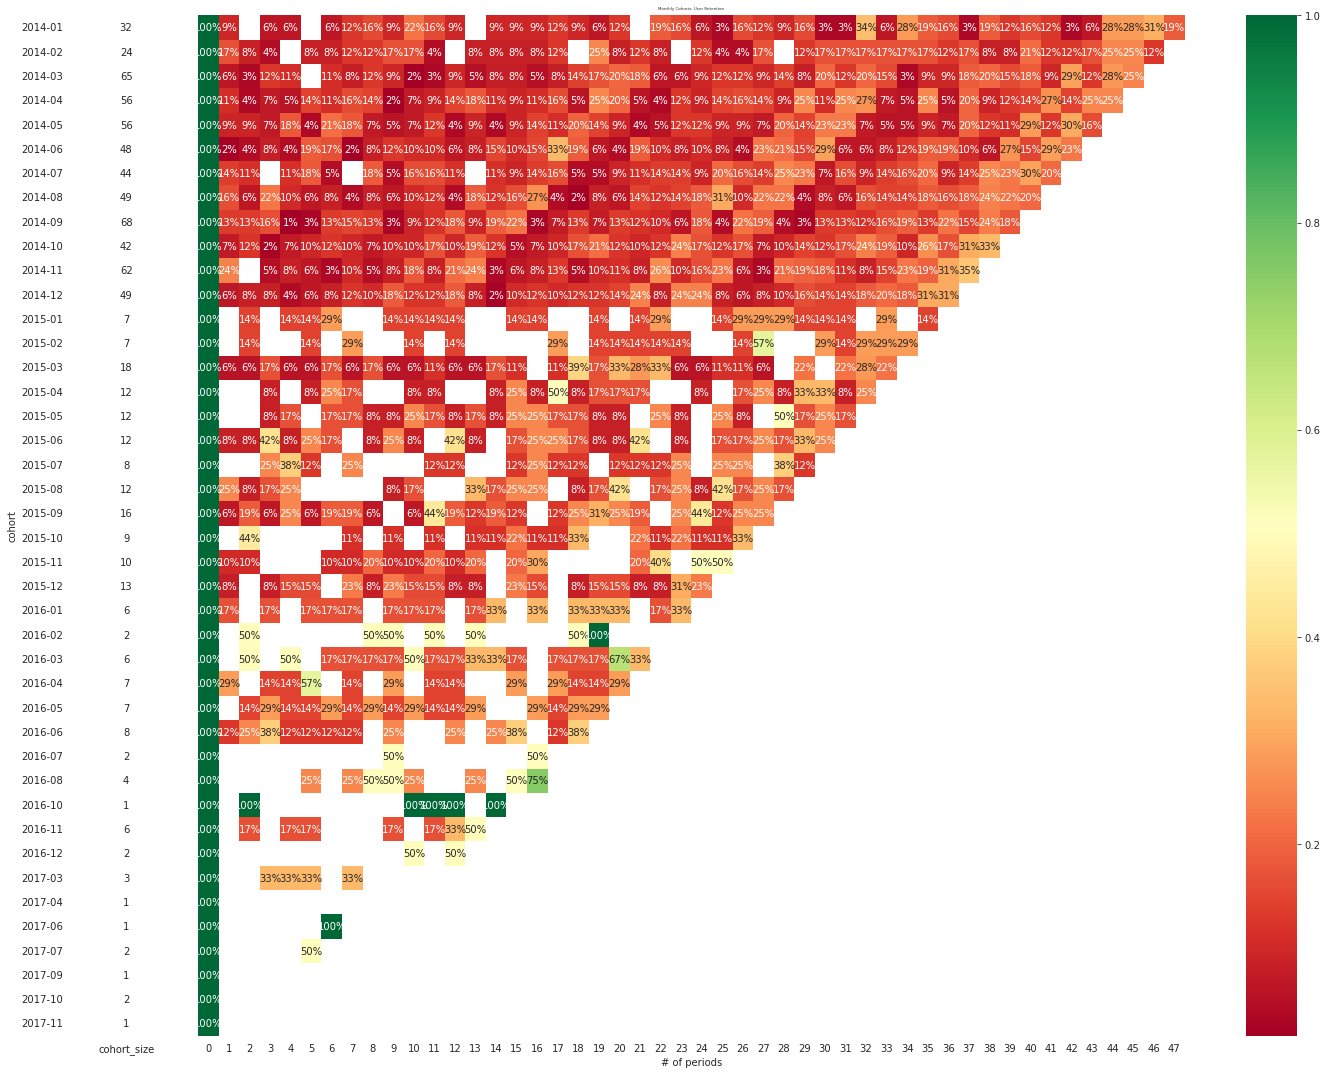

In [82]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(20, 15), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=4)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

Видим большое количество пропусков

### Вывод
Исходя из когортного анализа, в рассматриваемый промежуток времени, сайт переодически имел нестабильную работу, либо не имел в наличии предлагаемых продуктов, поскольку посещения сайта отсутствовали, либо продаж не было. Если рассматривать более стабильные периоды работы, наиболее удачными по удержанию клиентов были 10 и 11 месяцы 2014 года